в качестве первого задания мы предлагаем вам подготовить Jupyter ноутбук с базовым анализом задачи: считать данные (3 балла);

сделать визуализацию исходных данных с помощью seaborn (8 баллов);

грамотно организовать кросс-валидацию, построить классификатор одним из методов из семинаров 3-6, оценить качества классификации с помощью подходящих для задачи метрик (9 баллов)

проанализировать полученные данные и сделать выводы по итогам работы (5 баллов).

природа сигнала:

$H \rightarrow \tau \tau \rightarrow l h$

природа бэкграунда:
- $Z \rightarrow \tau \tau \rightarrow lh$
- $t \bar{t} \rightarrow l \tau$
- $W \rightarrow l \tau$


У каждого события:
- 1 tau (hadronic)
- 1 lepton (e or mu)
- 0 to 3 jets


The Loss function is given by:
    
$AMS = \sqrt{2 (s + b + b_r) log(1 + \frac{s}{b+b_r})  - s}$

# Сначала считаем данные и на них посмотрим и поймем, как их обрабатывать 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import datasets, linear_model, cross_validation
from sklearn.gaussian_process import GaussianProcess
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics.regression import mean_squared_error as mse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# LogisticRegressionCV automatically select regularization parameter C
sns.set()
%pylab inline

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
colormap = plt.cm.RdBu

Загрузим данные и заменим в столбце 'Lamel'

In [2]:
#url ="https://www.kaggle.com/c/higgs-boson/data/train.csv" //можно с сайта сразу скачать
#training = pd.read_csv(url)
training = pd.read_csv('training.csv')
training['target'] = training.Label.map(lambda l: 1.0 if l=='s' else 0.0)
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]
training.head(15).T#для удобства,чтобы посмотреть все признаки

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
EventId,100000,100001,100002,100003,100004,100005,100006,100007,100008,100009,100010,100011,100012,100013,100014
DER_mass_MMC,138.47,160.937,-999,143.905,175.864,89.744,148.754,154.916,105.594,128.053,-999,114.744,145.297,82.488,-999
DER_mass_transverse_met_lep,51.655,68.768,162.172,81.417,16.915,13.55,28.862,10.418,50.559,88.941,86.24,10.286,64.234,31.663,109.412
DER_mass_vis,97.827,103.235,125.953,80.943,134.805,59.149,107.782,94.714,100.989,69.272,79.692,75.712,103.565,64.128,14.398
DER_pt_h,27.98,48.146,35.635,0.414,16.405,116.344,106.13,29.169,4.288,193.392,27.201,30.816,106.999,8.232,17.323
DER_deltaeta_jet_jet,0.91,-999,-999,-999,-999,2.636,0.733,-999,-999,-999,-999,2.563,-999,-999,-999
DER_mass_jet_jet,124.711,-999,-999,-999,-999,284.584,158.359,-999,-999,-999,-999,252.599,-999,-999,-999
DER_prodeta_jet_jet,2.666,-999,-999,-999,-999,-0.54,0.113,-999,-999,-999,-999,-1.401,-999,-999,-999
DER_deltar_tau_lep,3.064,3.473,3.148,3.31,3.891,1.362,2.941,2.897,2.904,1.609,2.338,2.888,2.183,2.823,0.472
DER_pt_tot,41.928,2.078,9.336,0.414,16.405,61.619,2.545,1.526,4.288,28.859,27.201,36.745,24.66,8.232,17.323


 Посмотрим на список столбцов

In [10]:
training_cols = training.columns.tolist()
training_cols.sort
print(training_cols)

['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'Weight', 'Label', 'target']


In [17]:
training.info()#общая информация о типе данных и их количестве

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 34 columns):
EventId                        250000 non-null int64
DER_mass_MMC                   250000 non-null float64
DER_mass_transverse_met_lep    250000 non-null float64
DER_mass_vis                   250000 non-null float64
DER_pt_h                       250000 non-null float64
DER_deltaeta_jet_jet           250000 non-null float64
DER_mass_jet_jet               250000 non-null float64
DER_prodeta_jet_jet            250000 non-null float64
DER_deltar_tau_lep             250000 non-null float64
DER_pt_tot                     250000 non-null float64
DER_sum_pt                     250000 non-null float64
DER_pt_ratio_lep_tau           250000 non-null float64
DER_met_phi_centrality         250000 non-null float64
DER_lep_eta_centrality         250000 non-null float64
PRI_tau_pt                     250000 non-null float64
PRI_tau_eta                    250000 non-null float64
PRI_tau_phi

С первого взгляда на стаблицу видно немалое количество '-999'. Посмотрим, в каких признаках и сколько таких данных

In [15]:
for cols in training:
    missing = (training[cols] == -999.000)
    print (cols, missing.sum(), 'missing')

EventId 0 missing
DER_mass_MMC 38114 missing
DER_mass_transverse_met_lep 0 missing
DER_mass_vis 0 missing
DER_pt_h 0 missing
DER_deltaeta_jet_jet 177457 missing
DER_mass_jet_jet 177457 missing
DER_prodeta_jet_jet 177457 missing
DER_deltar_tau_lep 0 missing
DER_pt_tot 0 missing
DER_sum_pt 0 missing
DER_pt_ratio_lep_tau 0 missing
DER_met_phi_centrality 0 missing
DER_lep_eta_centrality 177457 missing
PRI_tau_pt 0 missing
PRI_tau_eta 0 missing
PRI_tau_phi 0 missing
PRI_lep_pt 0 missing
PRI_lep_eta 0 missing
PRI_lep_phi 0 missing
PRI_met 0 missing
PRI_met_phi 0 missing
PRI_met_sumet 0 missing
PRI_jet_num 0 missing
PRI_jet_leading_pt 99913 missing
PRI_jet_leading_eta 99913 missing
PRI_jet_leading_phi 99913 missing
PRI_jet_subleading_pt 177457 missing
PRI_jet_subleading_eta 177457 missing
PRI_jet_subleading_phi 177457 missing
PRI_jet_all_pt 0 missing
Weight 0 missing
Label 0 missing
target 0 missing


Попробуем получить наглядную картину корелляции признаков. Вдруг получится сразу угадать зависимости и избыточные признаки.  Для этого применим heatmap

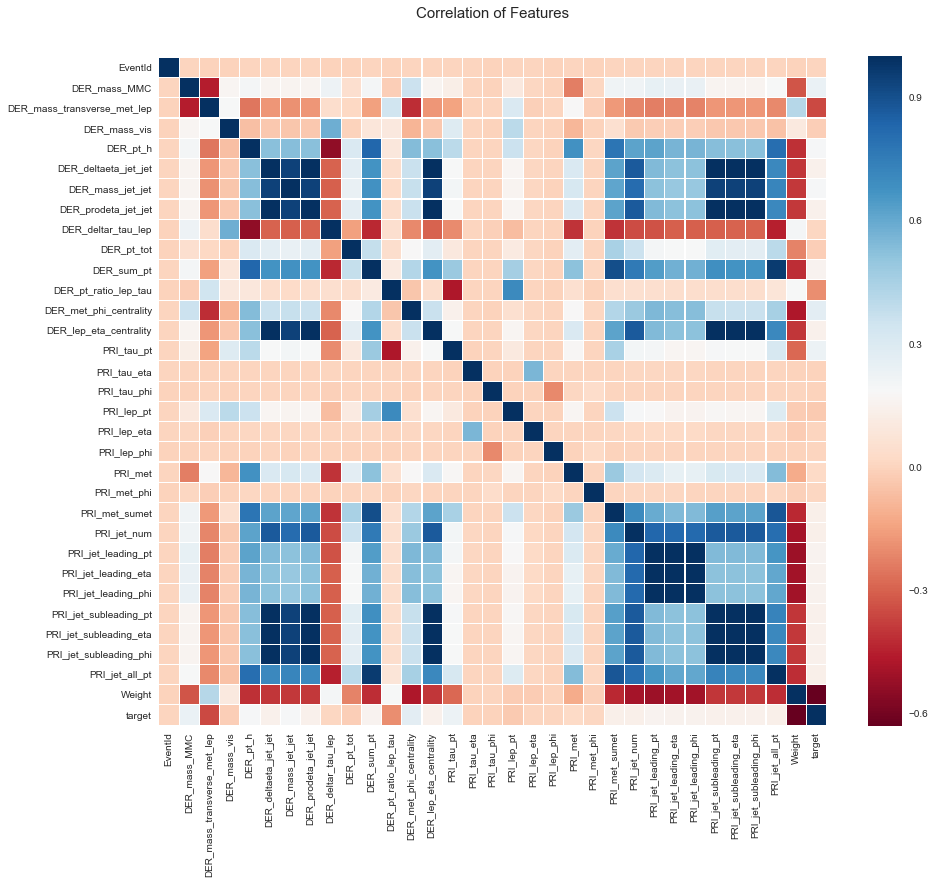

In [25]:
training_without_Label=training.drop(['Label'], axis=1)
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(training_without_Label.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)
plt.tight_layout()

Видно, что зависимость угадать сложно(хотя можно заметить, что, например, PRI_jet_subleading_eta и 
                                      PRI_jet_subleading_phi коллерируют)

Давайте посомтрим на корелляцию признаков

In [3]:
training.corr()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,target
EventId,1.000000,0.001917,-0.006059,-0.001851,0.002073,-0.000060,0.000353,-0.000075,-0.001349,-0.000581,...,0.000175,0.001396,0.001216,0.001214,-0.000065,-0.000068,-0.000060,0.001024,-0.002838,0.002248
DER_mass_MMC,0.001917,1.000000,-0.455755,0.168548,0.198765,0.162661,0.160524,0.162521,0.228105,0.045826,...,0.221078,0.250158,0.247083,0.247078,0.162836,0.162614,0.162609,0.185372,-0.327244,0.239149
DER_mass_transverse_met_lep,-0.006059,-0.455755,1.000000,0.190109,-0.249116,-0.176386,-0.190392,-0.175942,0.043251,0.017758,...,-0.210537,-0.229674,-0.220370,-0.220355,-0.176837,-0.176231,-0.176225,-0.210009,0.419843,-0.351428
DER_mass_vis,-0.001851,0.168548,0.190109,1.000000,-0.062562,-0.032251,-0.040620,-0.032126,0.579712,-0.000702,...,-0.026860,-0.019151,-0.013749,-0.013742,-0.033188,-0.032202,-0.032206,-0.052902,0.102172,-0.014055
DER_pt_h,0.002073,0.198765,-0.249116,-0.062562,1.000000,0.523664,0.534531,0.523639,-0.539379,0.310501,...,0.623401,0.621599,0.564898,0.564894,0.531647,0.523714,0.523703,0.808616,-0.414084,0.192526
DER_deltaeta_jet_jet,-0.000060,0.162661,-0.176386,-0.032251,0.523664,1.000000,0.946045,0.999981,-0.299076,0.270878,...,0.867521,0.545027,0.521657,0.521664,0.999346,0.999995,0.999996,0.712446,-0.395375,0.141646
DER_mass_jet_jet,0.000353,0.160524,-0.190392,-0.040620,0.534531,0.946045,1.000000,0.944443,-0.303751,0.247771,...,0.814191,0.521645,0.493233,0.493241,0.947652,0.945505,0.945507,0.719962,-0.394004,0.191766
DER_prodeta_jet_jet,-0.000075,0.162521,-0.175942,-0.032126,0.523639,0.999981,0.944443,1.000000,-0.299083,0.271435,...,0.867741,0.545022,0.521653,0.521661,0.999347,0.999988,0.999989,0.712620,-0.395004,0.140554
DER_deltar_tau_lep,-0.001349,0.228105,0.043251,0.579712,-0.539379,-0.299076,-0.303751,-0.299083,1.000000,-0.148081,...,-0.347904,-0.335851,-0.304161,-0.304145,-0.303416,-0.299107,-0.299101,-0.448737,0.197881,0.012245
DER_pt_tot,-0.000581,0.045826,0.017758,-0.000702,0.310501,0.270878,0.247771,0.271435,-0.148081,1.000000,...,0.360409,0.202920,0.186564,0.186590,0.279203,0.271100,0.271091,0.403382,-0.219507,-0.015287


In [124]:
# How do Higgs events distribute over number of jets?
for jet_num in range(0, 4):
    jet_num_filter  = (training['PRI_jet_num'] == jet_num)
    print ('jet_num %d\n'%(jet_num),training[jet_num_filter]['Label'].value_counts())

jet_num 0
 b    74421
s    25492
Name: Label, dtype: int64
jet_num 1
 b    49834
s    27710
Name: Label, dtype: int64
jet_num 2
 s    25734
b    24645
Name: Label, dtype: int64
jet_num 3
 b    15433
s     6731
Name: Label, dtype: int64


Возможно, стоит сгруппировать данные по jet_num:

In [179]:
training_grouped = training.groupby(by='PRI_jet_num')
training_grouped.describe().T

PRI_jet_num                              0             1             2  \
DER_deltaeta_jet_jet   count  99913.000000  77544.000000  50379.000000   
                       mean       0.000000      0.000000      0.994147   
                       std        0.000000      0.000000      0.001799   
                       min        0.000000      0.000000      0.991560   
                       25%        0.000000      0.000000      0.992537   
                       50%        0.000000      0.000000      0.993926   
                       75%        0.000000      0.000000      0.995535   
                       max        0.000000      0.000000      1.000000   
DER_deltar_tau_lep     count  99913.000000  77544.000000  50379.000000   
                       mean       2.664961      2.339686      2.060607   
                       std        0.693295      0.737633      0.759354   
                       min        0.277000      0.208000      0.228000   
                       25%        2.338000      1.855000      1.485000   
                       50%        2.822000      2.404000      2.020000   
                       75%        3.095000      2.855000      2.632000   
                       max        5.684000      5.655000      5.579000   
DER_lep_eta_centrality count  99913.000000  77544.000000  50379.000000   
                       mean       0.000000      0.000000      0.999493   
                       std        0.000000      0.000000      0.000399   
                       min        0.000000      0.000000      0.999000   
                       25%        0.000000      0.000000      0.999014   
                       50%        0.000000      0.000000      0.999551   
                       75%        0.000000      0.000000      0.999904   
                       max        0.000000      0.000000      1.000000   
DER_mass_MMC           count  99913.000000  77544.000000  50379.000000   
                       mean       0.377413      0.461814      0.481934   
                       std        0.225475      0.153973      0.122745   
                       min        0.000000      0.000000      0.000000   
                       25%        0.000000      0.494532      0.497755   
                       50%        0.500007      0.505213      0.507521   
...                                    ...           ...           ...   
PRI_tau_phi            std        1.817351      1.814460      1.815839   
                       min       -3.142000     -3.141000     -3.141000   
                       25%       -1.586000     -1.565000     -1.557000   
                       50%       -0.049000     -0.033000      0.001000   
                       75%        1.556000      1.566000      1.578000   
                       max        3.142000      3.141000      3.142000   
PRI_tau_pt             count  99913.000000  77544.000000  50379.000000   
                       mean      34.012723     38.589368     44.652267   
                       std       15.229541     21.005700     27.984075   
                       min       20.000000     20.000000     20.000000   
                       25%       23.655000     24.831000     26.401500   
                       50%       29.329000     32.159500     36.212000   
                       75%       39.808000     45.266000     53.052500   
                       max      764.408000    505.060000    622.862000   
Weight                 count  99913.000000  77544.000000  50379.000000   
                       mean       2.802141      1.242504      0.516427   
                       std        2.151360      1.287367      0.857842   
                       min        0.001502      0.001502      0.001502   
                       25%        0.018636      0.018636      0.001503   
                       50%        2.365683      1.454848      0.018636   
                       75%        4.778692      2.099019      0.744056   
                       max        7.769833      7.822543      7.805035   
targ

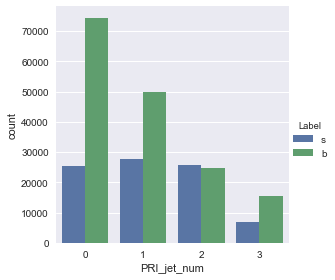

In [20]:
g = sns.factorplot(x = "PRI_jet_num", hue = "Label", kind="count",data = training);

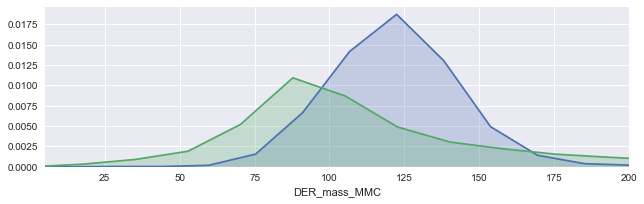

In [38]:
fg = sns.FacetGrid(training, hue = "Label", aspect = 3)
fg.map(sns.kdeplot, "DER_mass_MMC", shade = True)
fg.set(xlim=(5,200));

Здесь я смотрел на веса при линейной регрессии, но это ничего не решило

In [4]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

training_shuffled = shuffle(training, random_state=123)
X = scale(training_shuffled[training_shuffled.columns[:-2]])
y = training_shuffled["target"]

from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
linear_regression.fit(X,y)
for col, w in zip(training.columns, linear_regression.coef_):
    print(col, w)

EventId -0.00022685578199906054
DER_mass_MMC -0.007697409818952922
DER_mass_transverse_met_lep -0.04714952388920582
DER_mass_vis -0.02875604639488281
DER_pt_h 0.033842774924985185
DER_deltaeta_jet_jet -7.173654117929044
DER_mass_jet_jet 0.1577223894555076
DER_prodeta_jet_jet -4.401679359240208
DER_deltar_tau_lep 0.08131001156182804
DER_pt_tot -0.04249313067609384
DER_sum_pt -164.47576890983962
DER_pt_ratio_lep_tau -0.00485300832717761
DER_met_phi_centrality 0.013902464191624886
DER_lep_eta_centrality 15.37537302555962
PRI_tau_pt 31.914420094006584
PRI_tau_eta 0.0011516724541107415
PRI_tau_phi -8.643089690174577e-06
PRI_lep_pt 31.399193831235007
PRI_lep_eta -0.004018911409258807
PRI_lep_phi 0.0005967451287974823
PRI_met 0.03437832068833213
PRI_met_phi -5.75868604176244e-05
PRI_met_sumet -0.06963918027127436
PRI_jet_num -0.11903425678859358
PRI_jet_leading_pt -0.4464917339200687
PRI_jet_leading_eta 0.14590100841665055
PRI_jet_leading_phi 0.24445247392778569
PRI_jet_subleading_pt -0.33284

# Plots

1-ый график

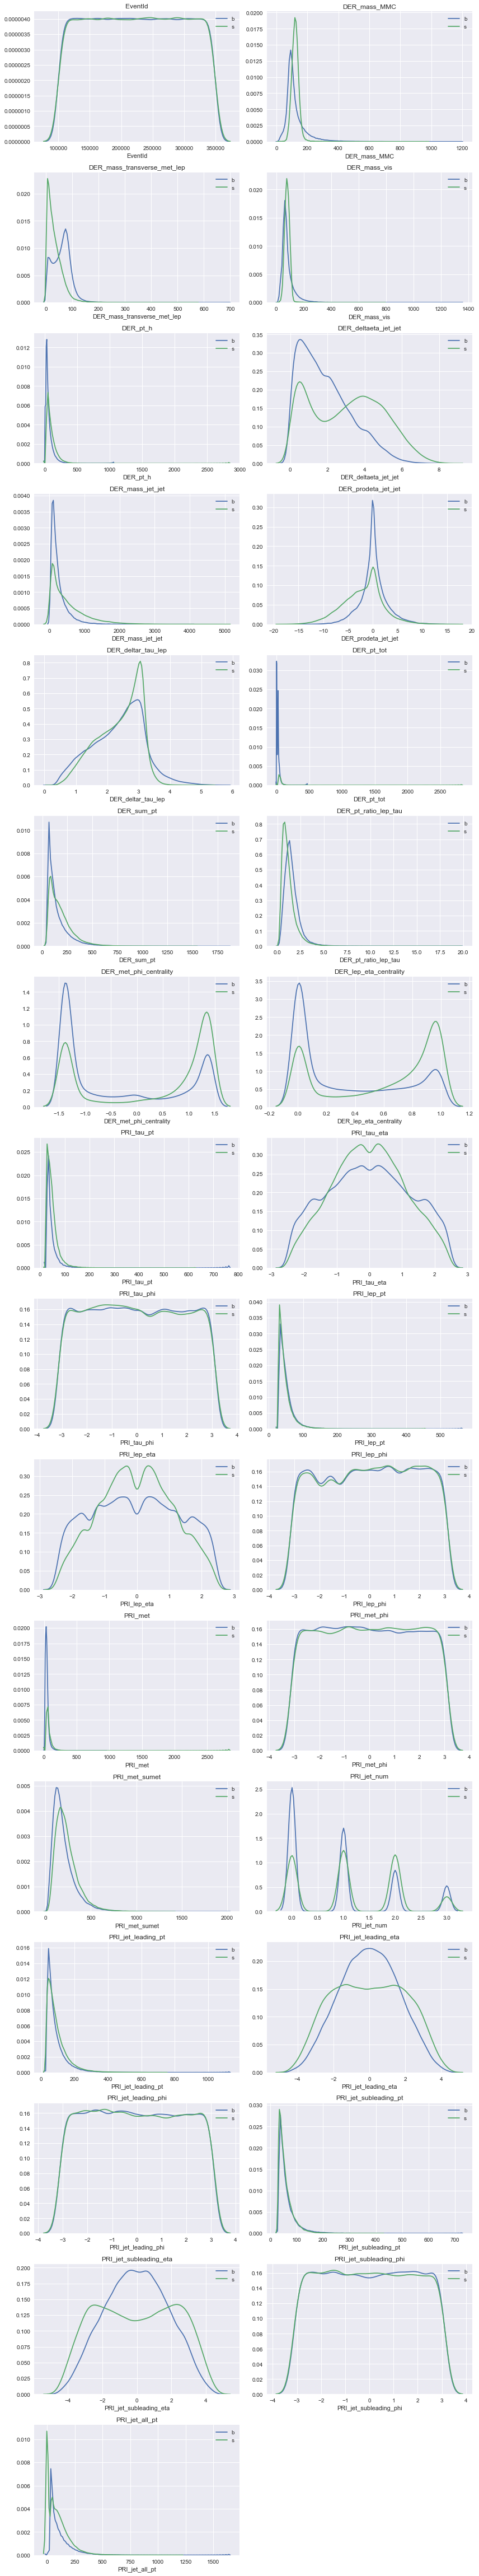

In [30]:
num_features = len(feature_cols)
ncols, nrows = 2, math.ceil(num_features / 2)

fig = plt.figure(figsize=(12, 4*nrows))

labels = training.Label.unique()

for i, f in enumerate(feature_cols):
    
    plt.subplot(nrows, ncols, i+1)
                  
    for label in ['b', 's']:
        sns.distplot(training[(training.Label==label) & (training[f] > -900)][f].dropna(), label=label, ax=plt.gca(),
                     hist=False, rug=False)            
    plt.title(f)
        
plt.tight_layout()

In [5]:
len(feature_cols)

31

2-ой график

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


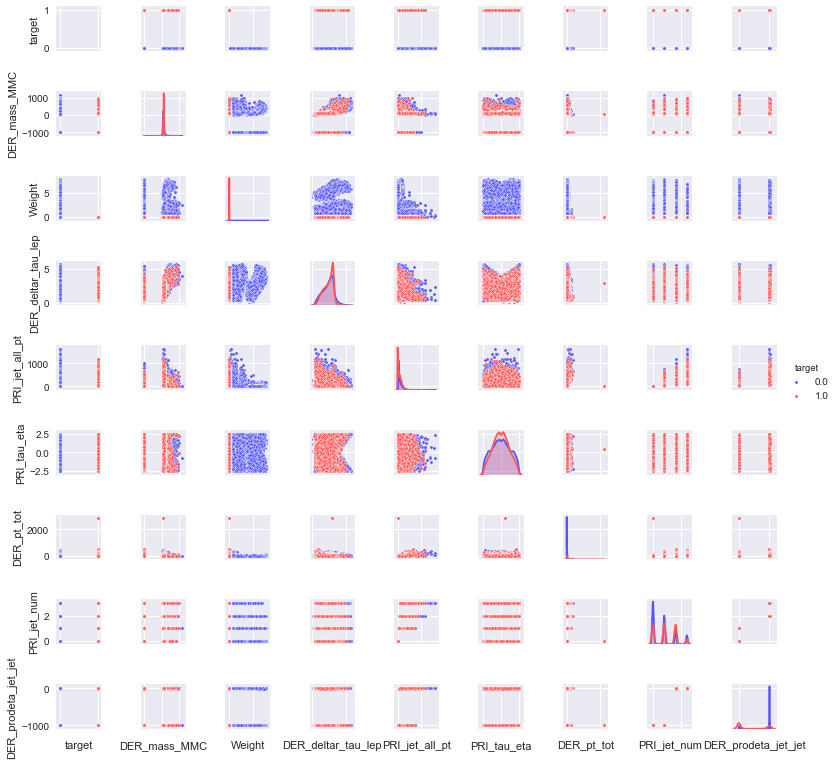

In [40]:
g = sns.pairplot(train[[u'target', u'DER_mass_MMC', u'Weight', u'DER_deltar_tau_lep', u'PRI_jet_all_pt', u'PRI_tau_eta', u'DER_pt_tot',
       u'PRI_jet_num', u'DER_prodeta_jet_jet']], hue='target', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

We hand select a number of features that appear to show good discrimination

In [200]:
selected_features = [
    'DER_mass_MMC',
    'DER_mass_transverse_met_lep',
    'DER_mass_vis',
    'DER_pt_h',
    'DER_deltaeta_jet_jet',
    'DER_mass_jet_jet',
    'DER_prodeta_jet_jet',
    'DER_deltar_tau_lep',
    'DER_sum_pt',
    'DER_pt_ratio_lep_tau',
    'DER_met_phi_centrality',
   'DER_lep_eta_centrality',
    'PRI_tau_pt',
   'PRI_tau_eta',
    'PRI_lep_eta',
    'PRI_jet_num',
    'PRI_jet_leading_eta',
    'PRI_jet_subleading_eta',
    'PRI_jet_all_pt',
    #Weight',
]
X=training[selected_features]
X.dropna(axis=0, inplace=True) # уберем все незаполненные данные

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Можем теперь посмотреть на перечень признаков в X

In [108]:
X.columns

Index(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_jet_num',
       'PRI_jet_leading_eta', 'PRI_jet_all_pt'],
      dtype='object')

// Метрика!!//

Напишем метрику, основываясь на инструкциях кагла, веса будем брать из данного нам признака(его мы дропнули для класификации)

In [22]:
def score_metric(y, y_pred):
    s=0
    b=0
    for i in range(len(y)):
        if(y_pred[i]*y[i]==1):
            s+=training.Weight[i]
        else:
            if(y_pred[i]==1 and y[i]==0):
                b+=training.Weight[i]
    return math.sqrt(2 *( (s+b+10.0) * math.log (1.0 + s/(b+10.0)) -s)) #метрика с кагла

## Логистическая регрессия

In [58]:
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# LogisticRegressionCV automatically select regularization parameter C
from sklearn import cross_validation, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

Определим несколько классификаторов

In [70]:
model_rfc = RandomForestClassifier(n_estimators = 40) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 5) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l2', tol=0.01) 
model_svc = svm.SVC() #по умолчанию kernek='rbf'
model_tree = DecisionTreeClassifier()

Применим сначала наш классификатор на весь тренировочный датасет без применения кросс-валидации

Сначала будем использовать LogisticRegressionCV()   
(для интереса посмотрим на обычное accuracy)

In [6]:
clf = LogisticRegressionCV()
#X = training.drop(['Label','target', 'Weight'], axis=1)
target=training.target
clf.fit(X, target)
print('Accuracy when trained on all dataset', np.mean(clf.predict(X) == target))

Accuracy when trained on all dataset 0.743164


In [38]:
model_lr.fit(X, target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False)

In [40]:
score_metric(target, model_lr.predict(X))

1.85591775385465

Давайте посмотрим на распределение фичей, попутно написав функцию, оценивающую вклад фичи

In [148]:
clf = LogisticRegressionCV(random_state = 0)

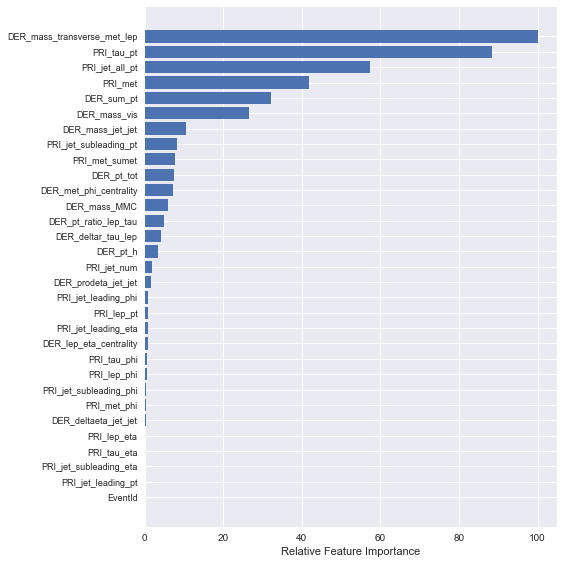

In [75]:
clf = LogisticRegression(random_state = 0)
clf.fit(X, target)
def features(clf, X):
    feature_importance = abs(clf.coef_[0])    # смотрим на получившийся коэффициент регрессии
    feature_importance = 100.0 * (feature_importance / feature_importance.max())  #
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(num=None, figsize=(8, 8))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center') #для горизонтального "бар" графика
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=9)
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout()   
    plt.show()
features(clf, X)

Видим, что в число информативных признаков вошли 12 Der и 3 Pri   
Таким образом, "производные" переменные(Derived) имеют более описательную ценность. Самым ниформативным оказался признак  DER_mass_transverse_met_lep(так называемая инвариантная масса относительно Лоренцевского буста по отношению к лептону). Поэтому среди наших "selected features" можем убрать PRI_tau_eta', 'PRI_lep_eta', 'PRI_jet_subleading_eta'

Посчитаем метрику

In [134]:
score_metric(target, clf.predict(X))

1.8378795314337006

Убираем фичи

In [201]:
selected_features.remove('PRI_jet_subleading_eta')
selected_features.remove('PRI_tau_eta')
selected_features.remove('PRI_lep_eta')

In [146]:
X=training[selected_features]

In [20]:
clf.fit(X, target)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [45]:
print('Score при LogisticRegressionCV: {0:.7f}'.format(score_metric(target, clf.predict(X))))

Score при LogisticRegressionCV: 1.9392831


Видим, что скор увеличился

А теперь вспомним наши запросы на признаки с пропущенными данными(-999) Отнормируем эти признаки.
Лучше использовать метод, который переносит все точки на заданный отрезок (обычно (0, 1))
Идеально подойдет: $$ \large X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

Нормируем DER_lep_eta_centrality,DER_mass_MMC, DER_deltaeta_jet_jet, DER_mass_jet_jet, DER_prodeta_jet_jet

In [202]:
data=training.DER_lep_eta_centrality
data.reshape(1, -1)
training.DER_lep_eta_centrality = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data=training.DER_mass_MMC
data.reshape(1, -1)
training.DER_mass_MMC = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data=training.DER_deltaeta_jet_jet
data.reshape(1, -1)
training.DER_deltaeta_jet_jet = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data=training.DER_mass_jet_jet
data.reshape(1, -1)
training.DER_mass_jet_jet = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data=training.DER_prodeta_jet_jet
data.reshape(1, -1)
training.DER_prodeta_jet_jet = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Снова фитим классификатором

In [149]:
clf.fit(X, target)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

И смотрим, как изменился скор:

In [150]:
print('Score при LogisticRegressionCV: {0:.7f}'.format(score_metric(target, clf.predict(X))))

Score при LogisticRegressionCV: 2.0242597


Ура, мы подняли скор!!!

Теперь применим LogisticRegression с параметрами l2 и l1 посмотрим, как изменился скор

In [52]:
model_lr = LogisticRegression(penalty='l2', tol=0.01)
model_lr.fit(X, target)
print('Score при LogisticRegression with l2: {0:.7f}'.format(score_metric(target, model_lr.predict(X))))
model_lr = LogisticRegression(penalty='l1', tol=0.01)
model_lr.fit(X, target)
print('Score при LogisticRegression with l1: {0:.7f}'.format(score_metric(target, model_lr.predict(X))))

Score при LogisticRegression with l2: 1.8559178
Score при LogisticRegression with l1: 1.9168692


Убеждаемся, что LogisticRegressionCV дает лучший результат

Давайте теперь построим Roc кривую и посмотрим визуально на получившийся график

напишем функцию для отрисовки Roc кривой

In [66]:
import pylab as pl
pl.clf()
def plot_roc(clf, X, target):
    plt.figure(figsize=(8,6))
    probas = clf.fit(X, target).predict_proba(X)
    fpr, tpr, thresholds = roc_curve(target, probas[:, 1])
    roc_auc  = auc(fpr, tpr) 
    pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.legend(loc=0, fontsize='small')
    pl.show() 

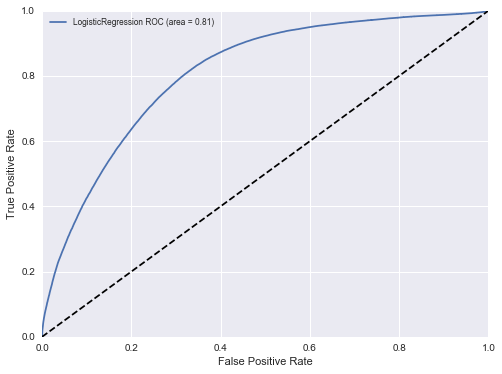

In [56]:
 plot_roc(clf, X, target)

Можем забежать немного вперед и посмотреть на скоры при KNeighborsClassifier, RandomForestClassifier
и DecisionTreeClassifier(ради интереса)

In [151]:
model_tree.fit(X,target)
print('Score при model_tree: {0:.7f}'.format(score_metric(target, model_tree.predict(X))))

Score при model_tree: 67.7111229


In [153]:
model_knc.fit(X,target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [154]:
print('Score при KNeighborsClassifier :{0:.7f}'.format(score_metric(target, model_knc.predict(X))))

Score при KNeighborsClassifier :3.0880417


In [155]:
model_rfc.fit(X, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [156]:
print('Score при RandomForestClassifier:{0:.7f}'.format(score_metric(target, model_rfc.predict(X))))

Score при RandomForestClassifier:51.4398440


Неоправданно высокий скор. Надо перемешать(кросс-валидировать данные)

Замечание: пробовал методом опорных векторов(SVC), работает очень долго!

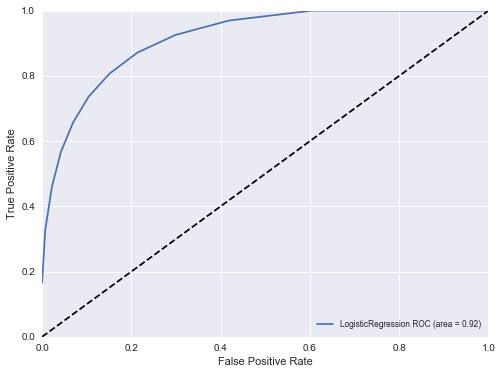

In [65]:
 plot_roc(model_knc, X, target)

Roc оказалcя больше, чем при Logistic regression

In [90]:
clf.coef_#можно полюбоваться нашими коэффициентами логистической регресси

array([[ 5.45316926e-04, -1.87691184e-02, -1.84852833e-02,
         4.95907490e-03, -1.66627831e-01,  2.38687674e-03,
        -4.71800858e-02,  8.09761161e-01,  3.09372995e-02,
        -6.09622956e-01,  1.41252867e-01,  2.12263107e-01,
        -1.12424254e-02, -5.33853540e-01,  8.66402110e-04,
        -3.71620956e-02]])

#   Настало время разбивать нашу дату

 Попробуем сначала на простом train_test_split

In [157]:
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, datasets, linear_model, metrics 

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, stratify = None, random_state = 0)

# TODO: 7. Fit on train set & estimate accuracy on the test set
clf = LogisticRegressionCV()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy when trained on a training subset', np.mean(y_pred == y_test))

Accuracy when trained on a training subset 0.7428


Можем точность посчитать и сами ручками

In [159]:
print(len(training.target))
print('hand-accuracy: {0:.3f}'.format(sum([1 if pair[0]==pair[1] else 0 for pair in zip(y_pred, y_test)])/len(y_test)))

250000
hand-accuracy: 0.743


In [160]:
float(len(y_test)/len(training))
print ('Размер обучающей выборки: {} объектов \nРазмер тестовой выборки: {} объектов'.format(len(X_train),
                                                                                            len(X_test)))

Размер обучающей выборки: 200000 объектов 
Размер тестовой выборки: 50000 объектов


Можем посмотреть на нашу обучающую и тестовую выборки

In [84]:
print ('Обучающая выборка:\n', X_train[:5])
print ('\n')
print ('Тестовая выборка:\n', X_test[:5])

Обучающая выборка:
         DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
148936       102.371                       40.887        68.822    61.761   
40192        108.189                       32.188        81.054    49.008   
157575      -999.000                       65.013        60.633     1.185   
61323       -999.000                       74.592       111.199   140.911   
206410       129.178                       73.068       107.920    33.121   

        DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
148936                 4.700           689.336               -5.511   
40192               -999.000          -999.000             -999.000   
157575              -999.000          -999.000             -999.000   
61323               -999.000          -999.000             -999.000   
206410                 3.391           292.477               -2.162   

        DER_deltar_tau_lep  DER_sum_pt  DER_pt_ratio_lep_tau  \
148936               2.241

classification report

Давайте посмотрим на нашу точность и полноту в компактной форме

In [161]:
print (metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.78      0.84      0.81     32871
        1.0       0.65      0.55      0.59     17129

avg / total       0.74      0.74      0.74     50000



Давайте снова посмотрим на скор

In [162]:
print('Score при LogisticRegressionCV(data_split) :{0:.7f}'.format(score_metric(target, clf.predict(X))))

Score при LogisticRegressionCV(data_split) :1.9903018


Как видно, score немного упал(по сравнению с целыми неразбитыми данными). Когда я не нормировал признаки он повышался(2,01).. Возможно зависимость между признаками более сложная и просто так отнормировать недостаточно(может еще log нужен)

Снова посмотрим на roc кривую

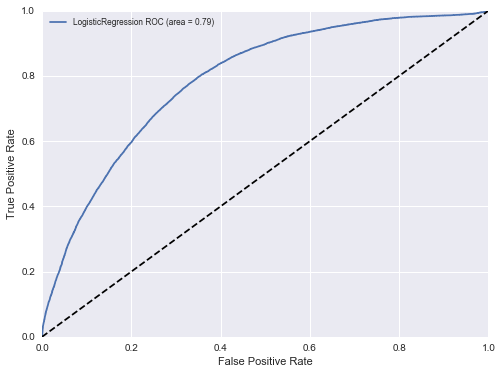

In [87]:
import pylab as pl
pl.clf()
plt.figure(figsize=(8,6))
probas = model_lr.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show() 

По сравнению с неразделенными данными ros_square уменьшилась(на 0.02)

In [ ]:
Давайте посмотрим, как изменился score при случайном лесе

In [163]:
model_rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [164]:
print('Score при RandomForestClassifier(split data):{0:.7f}'.format(score_metric(target, model_rfc.predict(X))))

Score при RandomForestClassifier(split data):8.5161420


теперь сделаем грамотное разбиение данных кросс-валидацией

# KFOLD

## Kfolds CV

<div style="width:60%; text-align:center">
<img src=http://vinhkhuc.github.io/assets/2015-03-01-cross-validation/5-fold-cv.png>
</div>

In [165]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
# KFold split our data
# cross_val_score automatically builds K models and then estimates errors on the corresponding test sets

In [219]:
kfold = KFold(n_splits=5, shuffle=True)
cv = kfold.split(X, target)

In [109]:
clf = LogisticRegressionCV()
scores = cross_val_score(clf, X, target, scoring='accuracy', cv=cv)
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.745 ± 0.004


In [220]:
clf = LogisticRegressionCV()
y_pred = cross_val_predict(clf, X, target, cv=cv)

In [224]:
print(classification_report(target, y_pred))

             precision    recall  f1-score   support

        0.0       0.78      0.85      0.81    164333
        1.0       0.65      0.53      0.58     85667

avg / total       0.73      0.74      0.73    250000



In [ ]:
Посмотрим опять на скор при LogisticRegressionCV

Это скор до нормировки данных:

In [113]:
print('Score при LogisticRegressionCV(Kfold) :{0:.7f}'.format(score_metric(target, y_pred)))

Score при LogisticRegressionCV(Kfold) :1.9645892


А это скор после нормировки данных:

In [168]:
print('Score при LogisticRegressionCV(Kfold) :{0:.7f}'.format(score_metric(target, y_pred)))

Score при LogisticRegressionCV(Kfold) :2.0202320


Скор случайного леса:

In [172]:
print('Score при RandomForestClassifier:{0:.7f}'.format(score_metric(target, cross_val_predict(model_rfc, X, target))))

Score при RandomForestClassifier:2.7682895


И на скор при KNeighborsClassifier:

In [120]:
print('Score при KNeighborsClassifier:{0:.7f}'.format(score_metric(target, cross_val_predict(model_knc, X, target))))

Score при KNeighborsClassifier:2.3141418


Видно, что доминирует RandomForestClassifier

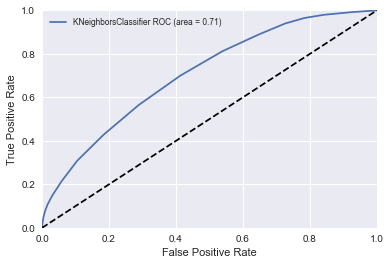

In [17]:
#KNeighborsClassifier
probas = model_knc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show() 

In [18]:
print(X.shape)

(250000, 32)


Давайте теперь построим Roc кривые уже для KFold(будем для каждого из n_splits разбиений строить ROC
                                                 и усредним)
И визуально посмотрим, у какого классификатора плащадь под Roc кривой больше

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


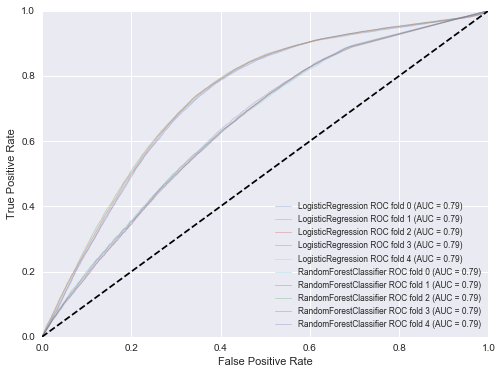

In [188]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
plt.figure(figsize=(8,6))
# KFold split your data
# cross_val_score automatically builds K models and then estimates errors on the corresponding test sets
cv = KFold(n_splits=5) # 5-fold CV
#cv = StratifiedKFold(n_splits=2)
classifier = LogisticRegression(penalty='l1', tol=0.01) 
classifier1 = RandomForestClassifier(n_estimators = 40)
i=0
X1=training.DER_mass_transverse_met_lep
X1=X1.reshape(-1,1)
for train, test in cv.split(X1, target):
    probas_ = classifier.fit(X1[train], target[train]).predict_proba(X1[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target[test], probas_[:, 1])
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='LogisticRegression ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
i=0
for train, test in cv.split(X1, target):
    probas_ = classifier1.fit(X1[train], target[train]).predict_proba(X1[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target[test], probas_[:, 1])
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='RandomForestClassifier ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

Что ж,как мы и видим из этой замечательной картинки, RandonForestClassifier(верхний график) действительно мощнее 

## GroupKFold

Давайте посмотрим, что произойдет при крос-валидацию при GroupKFold, вспомнив, что наши данные можно группировать по PRI_jet_num

In [215]:
training_grouped = training.groupby(by='PRI_jet_num')
training_grouped.describe()

DER_deltaeta_jet_jet                                         \
                           count      mean       std      min       25%   
PRI_jet_num                                                               
0                        99913.0  0.000000  0.000000  0.00000  0.000000   
1                        77544.0  0.000000  0.000000  0.00000  0.000000   
2                        50379.0  0.994147  0.001799  0.99156  0.992537   
3                        22164.0  0.993489  0.001459  0.99156  0.992269   

                                          DER_deltar_tau_lep           ...   \
                  50%       75%       max              count      mean ...    
PRI_jet_num                                                            ...    
0            0.000000  0.000000  0.000000            99913.0  2.664961 ...    
1            0.000000  0.000000  0.000000            77544.0  2.339686 ...    
2            0.993926  0.995535  1.000000            50379.0  2.060607 ...    
3            0.993183  0.994416  0.999379            22164.0  1.884620 ...    

               Weight             target                                     \
                  75%       max    count      mean       std  min  25%  50%   
PRI_jet_num                                                                   
0            4.778692  7.769833  99913.0  0.255142  0.435943  0.0  0.0  0.0   
1            2.099019  7.822543  77544.0  0.357346  0.479221  0.0  0.0  0.0   
2            0.744056  7.805035  50379.0  0.510808  0.499888  0.0  0.0  1.0   
3            0.744056  6.915521  22164.0  0.303691  0.459861  0.0  0.0  0.0   

                       
             75%  max  
PRI_jet_num            
0            1.0  1.0  
1            1.0  1.0  
2            1.0  1.0  
3            1.0  1.0  

[4 rows x 256 columns]

In [216]:
from sklearn.model_selection import GroupKFold
#we explicitly define our groups using PRI_jet_num

In [208]:
group_kfold = GroupKFold(n_splits=4)
cv = group_kfold.split(X, target, groups=training.PRI_jet_num)

In [210]:
clf = LogisticRegressionCV()
y_pred = cross_val_predict(clf, X, target, cv=cv)

Посмотрим теперь на скор при GroupKFold(n_splits=4):

In [212]:
print('Score при LogisticRegressionCV with GroupKFold:{0:.7f}'.format(score_metric(target, y_pred)))

Score при LogisticRegressionCV with GroupKFold:1.0441167


In [ ]:
Скор значительно упал. Значит, здесь лучше использовать кросс-валидаци. K-fold

Готовим файл для сабмита на кагл

In [16]:
test_data = pd.read_csv("test.csv")
test_data.head()

test_data = test_data.applymap(toNan)
test_data.set_index('EventId', inplace=True)
test_data.fillna(test_data.median(), inplace=True)
test_data.info()

sub = pd.DataFrame()#создаем табличку, где будем хранить данные для записи в сабмитный файл 
sub['EventId'] = test_data.index
sub['Proba'] = clf.predict_proba(test_data)[:, 1]
sub['Class'] = clf.predict(test_data)
sub['Class'] = sub['Class'].apply(lambda x: 'b' if x == 0 or x == 'b' else 's')
sub.head()

sub.sort_values(by=['Proba'], inplace=True)#соритируем данные по вероятности принадлежности к классу
sub['RankOrder'] = range(1, 550001)
sub.set_index('RankOrder', inplace=True)
sub.head(10)

with open("submission.csv", 'w') as f_out:
f_out.write("EventId,RankOrder,Class\n")
for rank_order in sub.index:
f_out.write(str(sub.loc[rank_order, 'EventId']) + ',' + str(rank_order) + ',' + str(sub.loc[rank_order, 'Class']) + '\n')

Для сортировки можно применить argsort

In [148]:
sub = pd.DataFrame()
w = test_data[selected_features]
sub['EventId'] = w.index
sub['Proba'] = clf.predict_proba(w)[:, 1]
sub['Class'] = clf.predict(w)
sub['Class'] = sub['Class'].apply(lambda x: 'b' if x == 0 or x == 'b' else 's')
sub['ranc']=np.argsort(sub['Proba'])
sub.head(45)

,EventId,Proba,Class,ranc
0,350000,0.036992,b,31419
1,350001,0.145834,b,180436
2,350002,0.310289,b,165771
3,350003,0.435120,b,31165
4,350004,0.031033,b,129702
5,350005,0.113927,b,183587
6,350006,0.242436,b,53056
7,350007,0.102115,b,103064
8,350008,0.153458,b,165662
9,350009,0.881357,s,431143


#  Вывод

В данной исследовательской работе мы применили общий инструмент машинного обучения для бинарной классификации. Была получена графическая физуализация признаков, после чего была видна сложная их зависимость. Была построена картина "относительной важности фичей" и установлено, что бохон Хиггса большей частью определяется массой(Derr_mass_...). Данные с пропропущенной датой(-999) были пронормированы, используя MinMax Scaling. Скор при этом вырос.Были использованы классификаторы:KNeighborsClassifier,  RandomForestClassifier, LogisticRegression. Самый высокий скор на трейне получался при RandomForestClassifier(score=2.7682895), как и следовало ожидать. Были построены ROC кривые, подтверждающие визуально эффективность классификаторов при целой дате и кросс-валидации. Были применены классификаторы при полной дате при разбивке на train и test и при кросс-валидации(K-fold и Group). Самым эффективным оказался Kfold. Были протестированы классификаторы на тесте(отправлены на кагл). Скор оказался максимальный при RandomForestClassifier(2.5667) 
